In [158]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [176]:
import jax
import jax.numpy as jnp
import jaxopt
import sympy
# from sympy.parsing.latex import parse_latex
# from sympy2jax import sympy2jax
import matplotlib.pyplot as plt
import scipy
import scipy.constants as const
import numpy as np
import math
from tqdm.notebook import tqdm

In [160]:
from jax.config import config
config.update("jax_enable_x64", True)

In [161]:
%matplotlib notebook

In [162]:
import scipy.special as sp

In [163]:
e = np.e
ln = np.log
ln_j = jnp.log
gamma_0 = sp.exp1
gamma_0_j = jax.scipy.special.exp1

In [164]:
# a = 1
R = jnp.float64(10)

This goes unstable around an alpha of 737 (for mirror ratios < 1000 the total value won't go above 222, it looks like). And that's just for 64 bit. 32 bit terminates around alpha of 83 and the derivative around an alpha of 39.

JAX 64 bit goes up to alpha of ~695, and ~342 for gradients

In [165]:
rhs_jax = lambda a, R: ((e ** (-a) / gamma_0_j(a) - a))*2/3 + 6 * (((e ** (-a) / gamma_0_j(a) - a)) * a ** 2 * ln_j(R) ** 2/(22.4) ** 2 * 3/2) ** (1/3)

In [166]:
rhs = lambda a, R: ((e ** (-a) - a*gamma_0(a))/gamma_0(a))*2/3 + 6 * (((e ** (-a) - a*gamma_0(a))/gamma_0(a)) * a ** 2 * ln(R) ** 2/(22.4) ** 2 * 3/2) ** (1/3)# + (((e ** (-a) - a*gamma_0(a))/gamma_0(a)) * a ** 2 * ln(R) ** 2/(22.4) ** 2 * 3/2) ** (1/6)

In [167]:
rhs_jax_grad = jax.grad(rhs_jax)

<IPython.core.display.Javascript object>


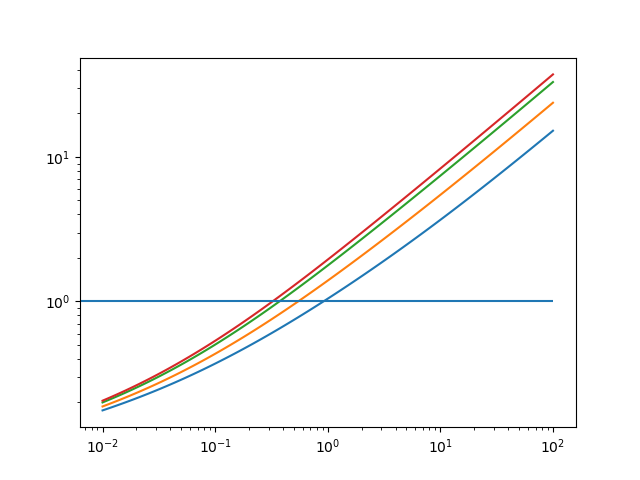

In [168]:
a = np.exp(np.linspace(np.log(0.01), np.log(100), 100))

plt.figure()
plt.plot(a, rhs(a, 2))
plt.plot(a, rhs(a, 4))
plt.plot(a, rhs(a, 10))
plt.plot(a, rhs(a, 16))
plt.hlines(1, -1, 101)
plt.xscale('log')
plt.yscale('log')

# jaxopt

In [169]:
from jaxopt import Bisection

## Calculate alpha

In [170]:
def fun_to_solve(a, R_in, power_aux_in):
    return rhs_jax(a, R_in) - (1 + power_aux_in)

In [219]:
@jax.jit
def find_alpha(R_in, power_aux_in):
    bisec = Bisection(optimality_fun=fun_to_solve, lower=0.1, upper=200.0, tol=1e-3, check_bracket=False, unroll=False)
    alpha = bisec.run(R_in=R_in, power_aux_in=power_aux_in).params
    return alpha

In [220]:
num_calcs = 20
power_aux = jnp.zeros(num_calcs)
R = jnp.linspace(2, 150, num_calcs)

In [226]:
alpha_arr = []
for i in tqdm(range(num_calcs)):
#     bisec = Bisection(optimality_fun=fun_to_solve, lower=0.1, upper=200.0, tol=1e-2, check_bracket=False, unroll=True)
#     alpha = bisec.run(R_in=R[i], power_aux_in=power_aux[i]).params
    alpha = find_alpha(R[i], power_aux[i])
    alpha_arr.append(alpha)

  0%|          | 0/20 [00:00<?, ?it/s]

In [227]:
jnp.array(alpha_arr)

DeviceArray([0.91441193, 0.37452087, 0.31504135, 0.28758926, 0.27005043,
             0.25861206, 0.24946136, 0.24183578, 0.23649788, 0.23115997,
             0.22734718, 0.22353439, 0.22048416, 0.21743393, 0.21514626,
             0.21285858, 0.21057091, 0.20828323, 0.20675812, 0.205233  ],            dtype=float64)

In [175]:
y = grad * a_tmp + b

0 = grad * alpha + b
b = 

y = alpha_grad_tmp * a_tmp + power_aux_tmp + 1 - alpha_grad_tmp * alpha_tmp

SyntaxError: cannot assign to literal here. Maybe you meant '==' instead of '='? (2368785142.py, line 3)

In [ ]:
alpha_grad_tmp

In [ ]:
alpha_tmp

In [ ]:
a_range = jnp.linspace(0.01, 5, 100)
R_tmp = 10.0
power_aux_tmp = 0.0
alpha_tmp = find_alpha(R_tmp, power_aux_tmp)
dalphadP = jax.grad(find_alpha, 1)(R_tmp, power_aux_tmp)
dalphadR = jax.grad(find_alpha, 0)(R_tmp, power_aux_tmp)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(a_range, fun_to_solve(a_range, R_tmp, power_aux_tmp), label="P_aux(Alpha)")
ax.vlines(alpha_tmp, -1, 5, color='green')
ax.hlines(0, 0, 5)
ax.plot(a_range, 1/dalphadP * (a_range - alpha_tmp), color='orange', label="1/(dAlpha / dP)")
ax.set_ylabel("Aux power in")
ax.set_xlabel("Alpha value")
ax.legend()

## From alpha calculate Ti

In [ ]:
def H(a):
    return a * gamma_0_j(a) / e ** -a

In [ ]:
def Ti_given_alpha(a):
    return ((e ** (-a) / gamma_0_j(a) - a))*2/3

In [ ]:
Ti_given_alpha(alpha)

In [ ]:
a_tmp = np.linspace(0, 1, 100)

plt.figure()
plt.plot(a_tmp, Ti_given_alpha(a))
plt.plot(a_tmp, H(a))

## From alpha calculate Te

In [ ]:
def Te_given_alpha(a, R):
    return (((e ** (-a) / gamma_0_j(a) - a)) * a ** 2 * ln_j(R) ** 2/(22.4) ** 2 * 2/3) ** (1/3)

In [ ]:
alpha_arr

In [ ]:
Te_given_alpha(jnp.array(alpha_arr), R)

In [ ]:
(3/2 * alpha / 22.4)**(2/3)  # This is the factor in front ln(R)^(2/3)

For power_aux = 0 and R = 10, the $T_i \sim 0.363$, and $T_e \sim 0.105 \sim 0.085 (\ln{R})^{2/3}$

Demonstration of the $T_e$ equation in Cary's spreadsheet vs solving for alpha for each mirror ratio case:

In [ ]:
plt.figure()
plt.plot(R, Te_given_alpha(jnp.array(alpha_arr), R), label="Calculated Te")
plt.plot(R, 0.089 * (ln(R)/ln(10))**(2/5), label="0.089 log_10(R)^(.4)")
plt.legend()
plt.ylabel('Te/E_beam')
plt.xlabel('Mirror ratio')

## Given Ti calculate alpha

In [ ]:
def Ti_to_solve(a):
    return ((e ** (-a) / gamma_0_j(a) - a)) - 0.6

In [ ]:
a = jnp.linspace(0.01, 20, 100)

plt.figure()
plt.plot(a, Ti_to_solve(a))

In [ ]:
bisec_Ti = Bisection(optimality_fun=Ti_to_solve, lower=0.1, upper=200.0, tol=1e-2)
result_Ti = bisec_Ti.run().params
result_Ti